In [1]:

import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from dataclasses import dataclass
import hvplot.pandas 
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# hv.renderer('bokeh').theme = 'dark_minimal'

In [2]:
# dataset_root = Path(r"C:\Users\Raffael\Documents\Datasets\alpiq_2023") # Raw string works without escaping \
# dataset_root = Path(r"C:/Users/jadbh\Documents/Swisse/EPFL/courses/Fall 2024/Machine Learning for Predictive Maintenance/project/Dataset")
# dataset_root = Path(r"C:\Users\jadbh\Documents\Swisse\EPFL\courses\Fall 2024\Machine Learning for Predictive Maintenance\project\team repo\Machine-Learning-for-Predictive-Maintenance-project\Dataset")
dataset_root = Path(r'Dataset')

@dataclass
class Case():
    info: pd.DataFrame
    measurements: pd.DataFrame


class RawDataset():

    def __init__(self, root, unit = "VG4", load_training=False, load_synthetic=False) -> None:
        
        
        read_pq_file = lambda f: pq.read_table(root / f).to_pandas()
        
        
        cases = {
            "test": [f"{unit}_generator_data_testing_real_measurements.parquet", root / f"{unit}_generator_data_testing_real_info.csv" ], 
        }
        
        if load_training:
            cases = {
                **cases,
                "train": [f"{unit}_generator_data_training_measurements.parquet", root / f"{unit}_generator_data_training_info.csv" ], 
            }
        
        if load_synthetic:
            cases = {
                **cases,
                "test_s01": [f"{unit}_generator_data_testing_synthetic_01_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_01_info.csv"], 
                "test_s02": [f"{unit}_generator_data_testing_synthetic_02_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_02_info.csv"]
            }
        
        
        self.data_dict = dict()
        
        for id_c, c in cases.items():
            # if you need to verify the parquet header:
            # pq_rows = RawDataset.read_parquet_schema_df(root / c[0])
            info = pd.read_csv(c[1])
            measurements = read_pq_file(c[0])
            self.data_dict[id_c] = Case(info, measurements)
            
        
        
    @staticmethod
    def read_parquet_schema_df(uri: str) -> pd.DataFrame:
        """Return a Pandas dataframe corresponding to the schema of a local URI of a parquet file.

        The returned dataframe has the columns: column, pa_dtype
        """
        # Ref: https://stackoverflow.com/a/64288036/
        schema = pq.read_schema(uri, memory_map=True)
        schema = pd.DataFrame(({"column": name, "pa_dtype": str(pa_dtype)} for name, pa_dtype in zip(schema.names, schema.types)))
        schema = schema.reindex(columns=["column", "pa_dtype"], fill_value=pd.NA)  # Ensures columns in case the parquet file has an empty dataframe.
        return schema
    

rds_u4 = RawDataset(dataset_root, "VG4", load_synthetic=False, load_training=True)
rds_u5 = RawDataset(dataset_root, "VG5", load_synthetic=True, load_training=True)
rds_u6 = RawDataset(dataset_root, "VG6", load_synthetic=True, load_training=True)

In [3]:
# Training vg5 turbine anomalies

vg5_train_meas = rds_u5.data_dict["train"].measurements
vg5_train_info = rds_u5.data_dict["train"].info
vg5_test_meas = rds_u5.data_dict["test"].measurements
vg5_test_info = rds_u5.data_dict["test"].info

In [4]:
vg5_train_filt_pump = vg5_train_meas [(vg5_train_meas['equilibrium_short_circuit_mode'] == True)]
    # (vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['dyn_only_on'] == False) ]
                                        #    (vg5_train_meas['equilibrium_turbine_mode'] == True)] 
                                        #    ((vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['short_circuit_mode'] == False)) |
                                        #    ((vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['short_circuit_mode'] == True) & (vg5_train_meas['equilibrium_short_circuit_mode'] == True)) ]

In [6]:
vg5_s1 = rds_u5.data_dict["test_s01"].measurements          # synthetic testing
vg5_s1.reset_index(inplace=True)
vg5_s1_filt_pump = vg5_s1 [(vg5_s1['equilibrium_short_circuit_mode'] == True)]


    #  (vg5_s1['equilibrium_pump_mode'] == True) & (vg5_s1['dyn_only_on'] == False)  ]        # filtered synthetic testing
                    # ((vg5_s1['equilibrium_pump_mode'] == True) & (vg5_s1['short_circuit_mode'] == False)) |
                    # ((vg5_s1['equilibrium_pump_mode'] == True) & (vg5_s1['short_circuit_mode'] == True) & (vg5_s1['equilibrium_short_circuit_mode'] == True)) ]

In [7]:

(vg5_s1)

,index,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,injector_01_opening,injector_02_opening,injector_03_opening,injector_04_opening,...,machine_on,machine_off,turbine_mode,all,equilibrium_turbine_mode,dyn_only_on,pump_mode,short_circuit_mode,equilibrium_pump_mode,equilibrium_short_circuit_mode
0,2021-06-01 00:00:00+02:00,68.560318,16.231133,16.937216,69.486435,9.034166,0.000000,61.281322,61.150532,0.0,...,True,False,True,True,False,True,False,False,False,False
1,2021-06-01 00:00:30+02:00,71.174561,16.183379,16.928701,70.857573,9.033857,38.503090,42.735943,42.796980,0.0,...,True,False,True,True,False,True,False,False,False,False
2,2021-06-01 00:01:00+02:00,73.023515,16.135625,16.920185,71.803329,9.033549,43.150226,43.049576,43.215415,0.0,...,True,False,True,True,False,True,False,False,False,False
3,2021-06-01 00:01:30+02:00,73.649020,16.087871,16.911669,72.867161,9.033240,43.920042,44.130617,43.877318,0.0,...,True,False,True,True,False,True,False,False,False,False
4,2021-06-01 00:02:00+02:00,76.121750,16.040118,16.903154,73.484650,9.032931,45.404236,45.356425,45.370260,0.0,...,True,False,True,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172735,2021-07-30 23:58:00+02:00,0.000000,23.435252,19.410579,4.540089,9.083500,0.000000,0.000000,0.000000,0.0,...,False,True,False,True,False,False,False,False,False,False
172736,2021-07-30 23:58:30+02:00,0.000000,23.426828,19.410112,4.385781,9.083500,0.000000,0.000000,0.000000,0.0,...,False,True,False,True,False,False,False,False,False,False
172737,2021-07-30 23:59:00+02:00,0.000000,23.418405,19.409645,4.627991,9.083500,0.000000,0.000000,0.000000,0.0,...,False,True,False,True,False,False,False,False,False,False
172738,2021-07-30 23:59:30+02:00,0.000000,23.409981,19.409178,4.400494,9.083500,0.000000,0.000000,0.000000,0.0,...,False,True,False,True,False,False,False,False,False,False


In [8]:
vg5_train_meas.reset_index(inplace=True)
vg5_train_filt_pump = vg5_train_meas[ (vg5_train_meas['equilibrium_short_circuit_mode'] == True)]
    # (vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['dyn_only_on'] == False) ]
# [ (vg5_train_meas['equilibrium_turbine_mode'] == True) ]
                                        #    ((vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['short_circuit_mode'] == False)) |
                                        #    ((vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['short_circuit_mode'] == True) & (vg5_train_meas['equilibrium_short_circuit_mode'] == True)) ]

In [9]:
# # # summary of VG5 useful variables

# vg5_train_info
# vg5_train_filt_pump     # equilibirum
# vg5_train_meas

# vg5_test_info
# vg5_test_meas

# vg5_s1
# vg5_s1_filt_pump         # equilibrium

# print()

In [9]:
df = vg5_train_filt_pump
print(df.columns)
df.head(3)

Index(['index', 'tot_activepower', 'ext_tmp', 'plant_tmp', 'charge',
       'coupler_position', 'injector_01_opening', 'injector_02_opening',
       'injector_03_opening', 'injector_04_opening', 'injector_05_opening',
       'pump_calculated_flow', 'pump_pressure_diff', 'pump_rotspeed',
       'tot_current', 'tot_effectivepower', 'tot_reactivepower',
       'turbine_pressure', 'turbine_rotspeed', 'water_primary_pump_01_opening',
       'water_primary_pump_02_opening', 'air_circ_cold_01_tmp',
       'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp',
       'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp',
       'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 'air_circ_hot_04_tmp',
       'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq',
       'exc_current', 'exc_voltage', 'mid_voltage', 'neutral_current',
       'ph01_current', 'ph01_voltage', 'ph12_voltage', 'ph02_current',
       'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_v

,index,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,injector_01_opening,injector_02_opening,injector_03_opening,injector_04_opening,...,machine_on,machine_off,turbine_mode,all,equilibrium_turbine_mode,dyn_only_on,pump_mode,short_circuit_mode,equilibrium_pump_mode,equilibrium_short_circuit_mode
1225,2020-01-02 10:12:30+01:00,-116.959740,6.187751,17.120198,-1.482010,185.033916,0.0,0.0,0.0,0.0,...,True,False,False,True,False,False,False,True,False,True
1259,2020-01-02 10:29:30+01:00,-116.942245,6.143241,17.201589,-1.525336,185.023748,0.0,0.0,0.0,0.0,...,True,False,False,True,False,False,False,True,False,True
1323,2020-01-02 11:01:30+01:00,-116.976814,6.754509,17.099826,-1.568675,185.053349,0.0,0.0,0.0,0.0,...,True,False,False,True,False,False,False,True,False,True


In [10]:
print("OG columns: ", df.columns.to_list())
print("OG columns length: ", len(df.columns.to_list()))
df.drop(columns=df.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
df.drop(['index'], axis = 1, inplace=True)
df.drop(columns= df.loc[:, 'injector_01_opening':'injector_05_opening'].columns, inplace= True)
print("final columns:       ", df.columns.to_list())
print("final columns lengthL", len(df.columns.to_list()))
df.sample(3)


OG columns:  ['index', 'tot_activepower', 'ext_tmp', 'plant_tmp', 'charge', 'coupler_position', 'injector_01_opening', 'injector_02_opening', 'injector_03_opening', 'injector_04_opening', 'injector_05_opening', 'pump_calculated_flow', 'pump_pressure_diff', 'pump_rotspeed', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'turbine_pressure', 'turbine_rotspeed', 'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'air_circ_cold_01_tmp', 'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage', 'ph31_voltage', 'stat_coil_ph01_01_tmp', 'stat_coil_ph01_02_tmp', 'stat_coi

C:\Users\user\AppData\Local\Temp\ipykernel_16048\1347542864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=df.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_16048\1347542864.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['index'], axis = 1, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_16048\1347542864.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,pump_calculated_flow,pump_pressure_diff,pump_rotspeed,tot_current,tot_effectivepower,...,water_circ_hot_02_tmp,water_circ_hot_03_tmp,water_circ_hot_04_tmp,water_circ_hot_05_tmp,water_circ_hot_06_tmp,water_circ_hot_tmp,air_gap_negative_x_position,air_gap_positive_x_position,air_gap_negative_y_position,air_gap_positive_y_position
1038123,-70.556745,7.791244,14.422811,-72.869334,185.044583,13.042837,345.516693,498.773315,2808.839321,73.729654,...,17.525000,17.700001,17.487903,17.500000,16.299999,17.433333,37.967519,33.112000,36.671343,35.036997
917959,-35.244112,10.321197,17.560886,-35.805156,185.029645,12.904854,342.450027,490.293335,1363.966952,36.396751,...,21.100000,20.700001,20.836363,20.700001,21.100000,22.000000,35.958336,33.279192,34.359001,34.997501
249406,-67.000893,15.519669,14.545029,-68.865341,185.075495,13.476937,365.137527,498.400024,2462.473405,67.154228,...,16.749423,16.550412,16.700001,16.630334,16.576471,16.645000,35.343969,32.302385,37.002088,35.172301


In [11]:
df_test = vg5_s1_filt_pump.copy()

print("OG columns: ", df_test.columns.to_list())
print("OG columns length: ", len(df_test.columns.to_list()))
df_test.drop(columns=df_test.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
df_test.drop(['index'], axis = 1, inplace=True)
df_test.drop(columns= df_test.loc[:, 'injector_01_opening':'injector_05_opening'].columns, inplace= True)
print("final columns:       ", df_test.columns.to_list())
print("final columns lengthL", len(df_test.columns.to_list()))
df_test.sample(3)

OG columns:  ['index', 'tot_activepower', 'ext_tmp', 'plant_tmp', 'charge', 'coupler_position', 'injector_01_opening', 'injector_02_opening', 'injector_03_opening', 'injector_04_opening', 'injector_05_opening', 'pump_calculated_flow', 'pump_pressure_diff', 'pump_rotspeed', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'turbine_pressure', 'turbine_rotspeed', 'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'air_circ_cold_01_tmp', 'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage', 'ph31_voltage', 'stat_coil_ph01_01_tmp', 'stat_coil_ph01_02_tmp', 'stat_coi

,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,pump_calculated_flow,pump_pressure_diff,pump_rotspeed,tot_current,tot_effectivepower,...,water_circ_hot_02_tmp,water_circ_hot_03_tmp,water_circ_hot_04_tmp,water_circ_hot_05_tmp,water_circ_hot_06_tmp,water_circ_hot_tmp,air_gap_negative_x_position,air_gap_positive_x_position,air_gap_negative_y_position,air_gap_positive_y_position
113056,-95.482315,23.392671,18.524237,-96.766223,185.024307,12.973899,343.416687,498.719971,3690.596897,97.839310,...,28.911111,28.666667,28.857142,28.686666,28.861538,28.760001,40.654677,38.429437,37.479064,36.162917
112701,-94.915324,23.199752,18.782285,-95.065063,185.026571,12.996833,342.277088,499.377787,3728.178174,97.614413,...,30.978114,30.910543,31.063441,31.166667,31.047436,31.045834,38.843124,37.118602,38.038502,36.625529
163217,-1.015429,33.540865,19.220613,-1.542978,9.274923,0.000000,-0.360067,-0.959981,1069.069830,27.200788,...,25.912612,25.799999,25.900000,25.785714,25.848317,25.815872,36.269020,33.458153,36.489974,34.978613


In [12]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
# Updated scaling function
def scale_data(train_df, test_df, feature_columns, scaler='minmax'):
    """
    Scales data per column using the specified scaler and avoids data leakage.
    Args:
        train_df (pd.DataFrame): Training data
        test_df (pd.DataFrame): Testing data
        feature_columns (list): Columns to be scaled
        scaler (str): Type of scaler ('minmax' or 'robust')
    Returns:
        scaled_train_df, scaled_test_df: Scaled versions of train and test data
        feature_ranges: Ranges of each feature after scaling
    """
    # Initialize the scaler
    if scaler == 'minmax':
        scaler_instance = MinMaxScaler()
    elif scaler == 'robust':
        scaler_instance = RobustScaler()
    else:
        raise ValueError("Unsupported scaler. Choose 'minmax' or 'robust'.")

    # Fit the scaler on training data
    scaler_instance.fit(train_df[feature_columns])

    # Transform both train and test data
    scaled_train_df = train_df.copy()
    scaled_test_df = test_df.copy()
    scaled_train_df[feature_columns] = scaler_instance.transform(train_df[feature_columns])
    scaled_test_df[feature_columns] = scaler_instance.transform(test_df[feature_columns])

    # Compute the range of each feature in the scaled training set
    feature_ranges = pd.DataFrame({
        "Feature": feature_columns,
        "Min": scaled_train_df[feature_columns].min().values,
        "Max": scaled_train_df[feature_columns].max().values
    })

    return scaled_train_df, scaled_test_df, feature_ranges

In [13]:
class SlidingWindowDataset(Dataset):
    def __init__(self, dataframe, feature_columns, window_size, step_size=1, max_gap=10, stride = 2):
        """
        Args:
            dataframe (pd.DataFrame): The dataframe containing sensor data.
            feature_columns (list): List of column names for features.
            window_size (int): The number of timesteps in each sliding window.
            step_size (int): The step size to slide the window.
            max_gap (int): Maximum allowed gap between consecutive indices for grouping.
        """
        self.features = dataframe[feature_columns].values
        self.indices = dataframe.index.values
        self.window_size = window_size
        self.step_size = step_size
        self.max_gap = max_gap
        self.stride = stride

        # Identify groups based on index gaps
        self.groups = self._identify_groups()
        # print(self.groups[0:50])
        # print(len(self.groups[500]))
        self.valid_windows = self._generate_valid_windows()

    def _identify_groups(self):
        """
        Identify groups of rows based on the max_gap condition.
        """
        groups = []
        current_group = [0]  # Start with the first row
        for i in range(1, len(self.indices)):
            if self.indices[i] - self.indices[i - 1] > self.max_gap:
                groups.append(current_group)
                current_group = [i]
            else:
                current_group.append(i)
        groups.append(current_group)  # Add the last group
        return groups

    def _generate_valid_windows(self):
        """
        Generate valid sliding windows based on groups.
        """
        valid_windows = []
        for group in self.groups:
            
            for start in range(0, len(group) - self.window_size + 1, self.stride):
                valid_windows.append(group[start : start + self.window_size])

            if (len(group) - self.window_size)%self.stride != 0 and len(group)> self.window_size:
                # print(len(group[len(group) - self.window_size : len(group)]))
                valid_windows.append(group[len(group) - self.window_size : len(group)])

        # print(valid_windows[-1])
        return valid_windows

    def __len__(self):
        return len(self.valid_windows)

    def __getitem__(self, idx):
        """
        Retrieve a sliding window by index.
        """
        window_indices = self.valid_windows[idx]
        x = torch.tensor(self.features[window_indices], dtype=torch.float32)
        original_indices = self.indices[window_indices] 
        return x

feature_columns = df.columns

feature_columns_test = df_test.columns
# feature_columns = ["charge"]
# feature_columns = df.columns.to_string()
window_size = 1000
stride = 100
max_gap = 1000
batch_size = 32
step_size = stride  # Step size for sliding window



train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle = False)
print("Total df shape:", df.shape)
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)


Total df shape: (105952, 84)
Training set shape: (84761, 84)
Testing set shape: (21191, 84)


Feature Ranges After Scaling:
                        Feature  Min  Max
0               tot_activepower  0.0  1.0
1                       ext_tmp  0.0  1.0
2                     plant_tmp  0.0  1.0
3                        charge  0.0  1.0
4              coupler_position  0.0  1.0
..                          ...  ...  ...
79           water_circ_hot_tmp  0.0  1.0
80  air_gap_negative_x_position  0.0  1.0
81  air_gap_positive_x_position  0.0  1.0
82  air_gap_negative_y_position  0.0  1.0
83  air_gap_positive_y_position  0.0  1.0

[84 rows x 3 columns]
train dataloader length:  12
train dataloader dataset length:  367
test dataloader length:  4
test dataloader dataset length:  123
Total windows: 367
Total number of groups: 183
Average points per group: 463.1748633879781
Minimum group size: 1


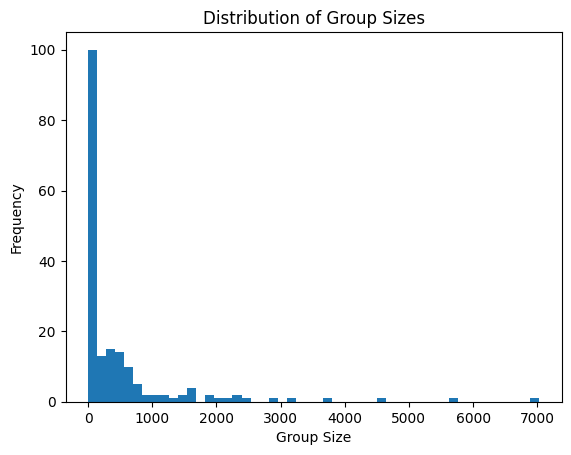

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example dataset setup
# Assuming `df` is already defined
window_size = 1000
stride = 100
max_gap = 1000
batch_size = 32
step_size = stride  # Step size for sliding window




train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

# Scale the data and get feature ranges
scaled_train_df, scaled_test_df, feature_ranges = scale_data(train_df, test_df, feature_columns, scaler='minmax')


# Display results
print("Feature Ranges After Scaling:")
print(feature_ranges)

# Here I am using the old scaling again, we can use the prints in a presentation or something

# Initialize a scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(train_df[feature_columns])

# Transform the training and testing data
train_df[feature_columns] = scaler.transform(train_df[feature_columns])
test_df[feature_columns] = scaler.transform(test_df[feature_columns])
df_test[feature_columns_test] = scaler.transform(df_test[feature_columns_test])  #synthetic anomalies


# Create Dataset and DataLoader
train_dataset = SlidingWindowDataset(train_df, feature_columns, window_size, step_size, max_gap, stride = stride)
test_dataset = SlidingWindowDataset(test_df, feature_columns, window_size, step_size, max_gap, stride = stride)
synth_test =  SlidingWindowDataset(df_test, feature_columns, window_size, step_size, max_gap, stride = stride)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
synth_test_loader = DataLoader(synth_test, batch_size=batch_size, shuffle=False)

print("train dataloader length: ", len(train_dataloader))
print("train dataloader dataset length: ", len(train_dataloader.dataset))

print("test dataloader length: ", len(test_dataloader))
print("test dataloader dataset length: ", len(test_dataloader.dataset))

print(f"Total windows: {len(train_dataset)}")
print(f"Total number of groups: {len(train_dataset.groups)}")
print(f"Average points per group: {np.mean([len(group) for group in train_dataset.groups])}")
group_sizes = [len(group) for group in train_dataset.groups]
print(f"Minimum group size: {min(group_sizes)}")
plt.hist(group_sizes, bins=50)
plt.xlabel('Group Size')
plt.ylabel('Frequency')
plt.title('Distribution of Group Sizes')
plt.show()

In [15]:
def add_noise(x, noise_factor=0.1):
    """
    Adds Gaussian noise to the input tensor.
    Args:
        x (torch.Tensor): Input tensor.
        noise_factor (float): Scale of noise to add.
    Returns:
        torch.Tensor: Noisy input tensor.
    """
    noisy_x = x + noise_factor * torch.randn_like(x)
    noisy_x = torch.clamp(noisy_x, 0, 1)  # Ensure values remain in the valid range
    return noisy_x

def custom_loss(x, x_reconstructed, encoded, sparsity_weight=1e-3):
    """
    Combines reconstruction loss with a sparsity constraint on the latent space.
    Args:
        x (torch.Tensor): Original input tensor.
        x_reconstructed (torch.Tensor): Reconstructed tensor.
        encoded (torch.Tensor): Latent representation.
        sparsity_weight (float): Weight for the sparsity penalty.
    Returns:
        torch.Tensor: Combined loss.
    """
    reconstruction_loss = nn.MSELoss()(x_reconstructed, x)
    sparsity_loss = torch.mean(torch.abs(encoded))  # L1 penalty for sparsity
    return reconstruction_loss + sparsity_weight * sparsity_loss


## Training loop with noise injection to improve robustness and residual connections 

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualConvAutoencoder(nn.Module):
    def __init__(self, input_dim, seq_len):
        super(ResidualConvAutoencoder, self).__init__()

        # Encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv1d(input_dim, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.LayerNorm([256, seq_len]),
        )
        self.encoder_conv2 = nn.Sequential(
            nn.Conv1d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.LayerNorm([128, seq_len//2]),
            nn.Dropout(p=0.2)
        )
        self.encoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.LayerNorm([64, seq_len//4])
        )
        self.encoder_pool = nn.MaxPool1d(2)  # Down-sampling at each stage

        # Latent space (larger latent space)
        self.latent = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1),  # Additional latent layer
            nn.ReLU(),
            nn.LayerNorm([64, seq_len//8])
        )

        # Decoder
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose1d(64, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.LayerNorm([64, seq_len//4])
        )
        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose1d(64+64, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.LayerNorm([128, seq_len//2]),
            nn.Dropout(p=0.2)
        )
        self.decoder_conv3 = nn.Sequential(
            nn.ConvTranspose1d(128+128, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.LayerNorm([256, seq_len])
        )
        self.output_layer = nn.Sequential(
            nn.Conv1d(256+256, input_dim, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Ensures output is in the range [0, 1]
        )

    def forward(self, x):
        """
        Forward pass with residual connections and latent space.
        """
        # Encoder
        x = x.permute(0, 2, 1)  # (batch_size, seq_len, features) -> (batch_size, features, seq_len)
        skip1 = self.encoder_conv1(x)  # First layer output for skip connection
        # print("ENCODER LAYER: 1",skip1.shape)
        skip2 = self.encoder_conv2(self.encoder_pool(skip1))  # Second layer output for skip
        # print("ENCODER LAYER: 2",skip2.shape)
        encoded = self.encoder_conv3(self.encoder_pool(skip2))  # Latent input
        # print("ENCODER LAYER: 3",encoded.shape)
        latent = self.latent(self.encoder_pool(encoded))  # Latent representation
        # print("ENCODER LAYER: 4",latent.shape)

        # Decoder
        decoded = self.decoder_conv1(latent)
        # print("RECONSTRUCTED: ",decoded.shape)
        decoded = torch.cat((decoded, encoded), dim=1)  # Align dimensions for skip connection
        # print("RECONSTRUCTED: ",decoded.shape)
        decoded = self.decoder_conv2(decoded)
        # print("FULLY RECONSTRUCTED: ",decoded.shape)
        decoded = torch.cat((decoded,skip2), dim=1)  # Align dimensions for skip connection
        decoded = self.decoder_conv3(decoded)
        # print("FULLY RECONSTRUCTED: ",decoded.shape)
        decoded = torch.cat((decoded,skip1), dim=1)  # Align dimensions for skip connection
        decoded = self.output_layer(decoded)  # Final reconstruction
        # print("FULLY RECONSTRUCTED: ",decoded.shape)
        # Revert to (batch_size, seq_len, features)
        return decoded.permute(0, 2, 1), latent


In [17]:
import torch
import numpy as np
import random
from tqdm import tqdm

def train_loop(dataloader, model, optimizer, noise_factor=0.1, sparsity_weight=1e-3):
    model.train()
    total_loss = 0

    for x in tqdm(dataloader):
        optimizer.zero_grad()

        # Add noise to input
        # noisy_x = add_noise(x, noise_factor)

        # Forward pass
        reconstructed, encoded = model(x) # because x is the batches and the indices

        # Compute loss
        loss = custom_loss(x, reconstructed, encoded, sparsity_weight)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def test_loop(dataloader, model, sparsity_weight=1e-3):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x in dataloader:
            reconstructed, encoded = model(x)
            loss = custom_loss(x, reconstructed, encoded, sparsity_weight)
            total_loss += loss.item()

    return total_loss / len(dataloader)



def set_seed(seed=42):
    """
    Set a constant seed for reproducibility across all libraries.
    Args:
        seed (int): The seed value to use.
    """
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # Numpy
    torch.manual_seed(seed)  # PyTorch (CPU)
    torch.cuda.manual_seed(seed)  # PyTorch (GPU)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Avoids nondeterministic algorithms



## Training loop with noise injection for robustness, introducing sparcity loss, batchnorm and dropout for overfitting and stability, and early stopping to get the best model

In [18]:
set_seed(42)
# Hyperparameters
epochs = 200
learning_rate = 0.001
noise_factor = 0.1
sparsity_weight = 1e-3

# Model, optimizer, and dataloaders
input_dim = 84  # for pump, and 85 for turbine
seq_len = 1000
model = ResidualConvAutoencoder(input_dim, seq_len)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_loss_evol, test_loss_evol = [], []

best_test_loss = float('inf')
patience = 10
patience_counter = 0

In [19]:
for x in train_dataloader:
    print(x[0].shape)  # Verify shape
    break


torch.Size([1000, 84])


In [20]:
# # TRAINING LOOP:
# # print(model)
# for epoch in range(epochs):
#     train_loss = train_loop(train_dataloader, model, optimizer, noise_factor, sparsity_weight)
#     test_loss = test_loop(test_dataloader, model, sparsity_weight)

#     print(f"Epoch: {epoch}, Training Loss: {train_loss}, Validation Loss: {test_loss}")
#     train_loss_evol.append(train_loss)
#     test_loss_evol.append(test_loss)
#     if test_loss < best_test_loss:
#         best_test_loss = test_loss
#         patience_counter = 0  # Reset patience
#         torch.save(model.state_dict(), 'best_model_VG6_SC.pth')  # Save the best model
#         print(f"New best model at epoch {epoch}")
#     # else:
#     #     patience_counter += 1
#     #     if patience_counter >= patience:
#     #         print(f"Early stopping at epoch {epoch}")
#     #         break




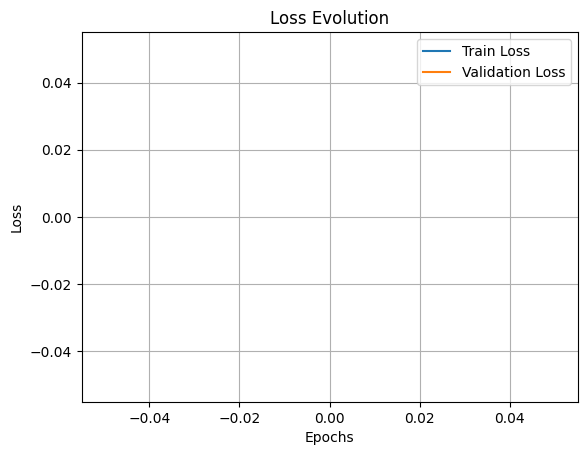

In [19]:
# Plot loss evolution
import matplotlib.pyplot as plt

plt.plot((train_loss_evol), label='Train Loss')
plt.plot((test_loss_evol), label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.legend()
plt.grid()
plt.show()

Batch shape: torch.Size([32, 1000, 84])
Single sample shape: torch.Size([1, 1000, 84])


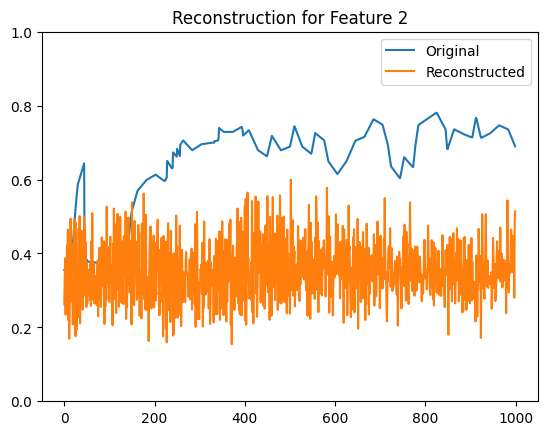

In [19]:
# Access the first batch of the test dataloader
with torch.no_grad():
    # print(len(test_dataloader))
    # Get the first batch from the dataloader
    for  x in test_dataloader:
        # x will have the shape (batch_size, seq_len, num_features)
        print("Batch shape:", x.shape)
        
        
        # Use only the first element in the batch
        x_sample = x[1].unsqueeze(0)  # Shape: (1, seq_len, num_features)
        print("Single sample shape:", x_sample.shape)
        
        # Pass it through the model
        reconstructed, _ = model(x_sample)
        
        # Remove batch dimension for visualization
        x_sample = x_sample.squeeze(0)  # Shape: (seq_len, num_features)
        reconstructed = reconstructed.squeeze(0)  # Shape: (seq_len, num_features)
        
        # Plot the original and reconstructed signal for one feature
        
        feature_index = 2
          # Adjust to visualize a specific feature
        plt.plot(x_sample[:, feature_index].cpu().numpy(), label="Original")
        plt.plot(reconstructed[:, feature_index].cpu().numpy(), label="Reconstructed")
        plt.legend()
        plt.title(f"Reconstruction for Feature {feature_index}")
        plt.ylim([0, 1])
        plt.show()
        
      # Break after first batch
        break


In [20]:
model.load_state_dict(torch.load("best_model_VG5_SC.pth"))  # Load the trained model weights
model.eval()  # Set the model to evaluation mode


C:\Users\user\AppData\Local\Temp\ipykernel_16048\4252453981.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_VG5_SC.pth"))  #

ResidualConvAutoencoder(
  (encoder_conv1): Sequential(
    (0): Conv1d(84, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): LayerNorm((256, 1000), eps=1e-05, elementwise_affine=True)
  )
  (encoder_conv2): Sequential(
    (0): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): LayerNorm((128, 500), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): LayerNorm((64, 250), eps=1e-05, elementwise_affine=True)
  )
  (encoder_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (latent): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): LayerNorm((64, 125), eps=1e-05, elementwise_affine=True)
  )
  (decoder_conv1): Sequential(
    (0): ConvTranspose1d(64, 64, kernel_size=(2,), stride=(2,))
    

In [21]:
import torch

# Disable gradient computation for evaluation
with torch.no_grad():
    total_loss = 0
    # full_reconstruction = torch.Tensor([])
    for x in synth_test_loader:
        # inputs, _ = batch  # Adjust this based on your data structure
        outputs, encoded = model(x)  # Forward pass through the model
        
        # Compute loss (if applicable)
        # full_reconstruction = torch.cat((full_reconstruction, outputs), dim=0)
        loss = custom_loss(x, outputs, encoded, sparsity_weight)  # Replace `loss_function` with your criterion
        total_loss += loss.item()
        
        # You can also compute additional metrics like accuracy or reconstruction error here

print(f"Test Loss: {total_loss / len(synth_test_loader)}")


Test Loss: 0.001761823077686131


Single sample shape: torch.Size([1, 1000, 84])


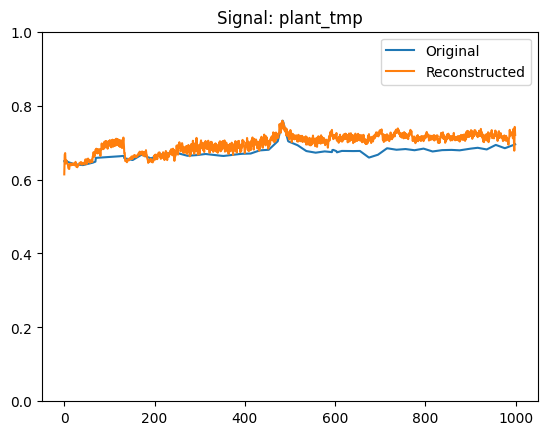

In [22]:
# Access the first batch of the test dataloader
with torch.no_grad():
    # print(len(synth_test_loader))
    # Get the first batch from the dataloader
    for x in synth_test_loader:
        for i in range(len(x)):
        # x will have the shape (batch_size, seq_len, num_features)
            # print("Batch shape:", x.shape)
            # print(i)
            
            
            # Use only the first element in the batch
            x_sample = x[i].unsqueeze(0)  # Shape: (1, seq_len, num_features)

            print("Single sample shape:", x_sample.shape)
            
            # Pass it through the model
            reconstructed, _ = model(x_sample)
            
            # Remove batch dimension for visualization
            x_sample = x_sample.squeeze(0)  # Shape: (seq_len, num_features)
            reconstructed = reconstructed.squeeze(0)  # Shape: (seq_len, num_features)
        
            # Plot the original and reconstructed signal for one feature
            feature_index = 2  # Adjust to visualize a specific feature
            plt.plot(x_sample[:, feature_index].cpu().numpy(), label="Original")
            plt.plot(reconstructed[:, feature_index].cpu().numpy(), label="Reconstructed")
            plt.legend()
            plt.title(f"Signal: {df.columns[feature_index]}")
            plt.ylim([0,1])
            plt.show()
                
            # Break after first batch
            
            break
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
# df_complete_synth_test = vg5_s1.copy()

# df_complete_synth_test.drop(columns=df_complete_synth_test.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
# df_complete_synth_test.drop(['index'], axis = 1, inplace=True)
# df_complete_synth_test.drop(columns= df_complete_synth_test.loc[:, 'injector_01_opening':'injector_05_opening'].columns, inplace= True)



In [23]:
seq_len = 1000
model_turbine= ResidualConvAutoencoder(85, seq_len)
model_pump   = ResidualConvAutoencoder(84, seq_len)
model_scm    = ResidualConvAutoencoder(84, seq_len)


In [24]:
model_scm.load_state_dict(torch.load("best_model_VG5_SC.pth"))  # Load the trained model weights
model_scm.eval()  # Set the model to evaluation mode

model_pump.load_state_dict(torch.load("best_model_VG5_PUMP.pth"))  # Load the trained model weights
model_pump.eval()  # Set the model to evaluation mode

model_turbine = torch.load("best_model_VG5_TURBINE.pth")  # Load the trained model weights
model_turbine.eval()  # Set the model to evaluation mode

C:\Users\user\AppData\Local\Temp\ipykernel_16048\1060446530.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_scm.load_state_dict(torch.load("best_model_VG5_SC.pth")

ResidualConvAutoencoder(
  (encoder_conv1): Sequential(
    (0): Conv1d(85, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): LayerNorm((256, 1000), eps=1e-05, elementwise_affine=True)
  )
  (encoder_conv2): Sequential(
    (0): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): LayerNorm((128, 500), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): LayerNorm((64, 250), eps=1e-05, elementwise_affine=True)
  )
  (encoder_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (latent): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): LayerNorm((64, 125), eps=1e-05, elementwise_affine=True)
  )
  (decoder_conv1): Sequential(
    (0): ConvTranspose1d(64, 64, kernel_size=(2,), stride=(2,))
    

In [ ]:
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def detect_anomalies_with_models(
    df, model_turbine, model_pump, model_scm, threshold, window_size=1000, stride=100, device="cpu"
):
    """
    Detect anomalies in a synthetic dataframe based on operating conditions using autoencoder models.
    
    Args:
        df (pd.DataFrame): Input dataframe containing features + operating conditions.
        model_turbine (torch.nn.Module): Autoencoder model for turbine condition.
        model_pump (torch.nn.Module): Autoencoder model for pump condition.
        model_scm (torch.nn.Module): Autoencoder model for short circuit mode.
        threshold (float): Threshold for anomaly detection based on reconstruction error.
        window_size (int): Size of the time window.
        stride (int): Stride for the sliding window.
        device (str): Device to run models ('cpu' or 'cuda').
        
    Returns:
        alarm_signal (list): A binary list indicating anomalies (1) or normal (0) for each window.
    """
    alarm_signal = []
    reconstructed_signals = []
    df_copy = df.copy()
    df_copy1 = df.copy()
    


    df_copy1['injector_mean'] = df[['injector_01_opening', 'injector_02_opening', 'injector_03_opening', 'injector_04_opening', 'injector_05_opening']].mean(axis =1)
    
    scaler = MinMaxScaler()

    # Loop through the dataframe using the sliding window
    for start_idx in range(0, len(df) - window_size + 1, stride):
        end_idx = start_idx + window_size
        window = df_copy.iloc[start_idx:end_idx].copy()
        window_timestamps = window['index']


        if window["equilibrium_turbine_mode"].all():  # Turbine condition
            if "injector_mean" not in window.columns:
                df_copy["injector_mean"] = df_copy1['injector_mean']
            x = scaler.fit_transform(window.iloc[:, 1:86].values)  
            x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
            model_turbine.eval()
            with torch.no_grad():
                x_reconstructed, _ = model_turbine(x_tensor)
            x_reconstructed = x_reconstructed.squeeze(0).cpu().numpy()

        elif window["equilibrium_pump_mode"].all():  
            if "injector_mean" in window.columns:
                window.drop(['injector_mean'], axis = 1, inplace=True)


            x = scaler.fit_transform(window.iloc[:, 1:85].values)
            x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
            model_pump.eval()
            with torch.no_grad():
                x_reconstructed, _ = model_pump(x_tensor)
            x_reconstructed = x_reconstructed.squeeze(0).cpu().numpy()

        elif window["equilibrium_short_circuit_mode"].all(): 
            x = scaler.fit_transform(window.iloc[:, 1:85].values)
            x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
            model_scm.eval()
            with torch.no_grad():
                x_reconstructed, _ = model_scm(x_tensor)
            x_reconstructed = x_reconstructed.squeeze(0).cpu().numpy()
        else:
            continue  # Skip the window if none of the conditions are met


        reconstructed_signals.append((window_timestamps, x_reconstructed))
        # Compute reconstruction error
        reconstruction_error = ((x - x_reconstructed) ** 2).mean()

        # If anomaly detected
        all_anomalous_features = []  # Store anomalous features for all windows

        if reconstruction_error > threshold:
            feature_contributions = {}
            feature_threshold = 0.1  # Adjust as needed

            for i in range(x.shape[1]):
                feature_error = np.abs(x[:, i] - x_reconstructed[:, i]).mean()
                feature_contributions[i] = feature_error

            anomalous_features = [i for i, error in feature_contributions.items() if error > feature_threshold]
            all_anomalous_features.append(anomalous_features)
            alarm_signal.append(1)
        else:
            all_anomalous_features.append([])  # No anomalous features
            alarm_signal.append(0)


    return alarm_signal, reconstructed_signals


In [80]:
# Assuming `df_complete_synth_test` is your synthetic dataframe and models are preloaded
alarm_signal, recon_signals = detect_anomalies_with_models(
    vg5_s1, 
    model_turbine, 
    model_pump, 
    model_scm, 
    threshold=0.075, 
    window_size=1000, 
    stride=50, 
    device="cuda" if torch.cuda.is_available() else "cpu"
)

print(alarm_signal)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [106]:
import matplotlib.pyplot as plt

def plot_anomaly_detection(df, alarm_signal, reconstructed, feature_name='plant_tmp', title="Anomaly Detection Results"):
    """
    Plot the results of anomaly detection including original data, anomalies, and ground truth.
    
    Args:
        df (pd.DataFrame): Original dataframe containing the features and ground truth labels.
        alarm_signal (list): Anomaly signal (1 for anomaly, 0 for normal) for each window.
        title (str): Title of the plot.
    """
    # Ensure the alarm signal aligns with the time range
    timestamps = df.index[:len(alarm_signal)]
    reconstructed_timestamps = [t[0] for t in reconstructed]  # Timestamps of reconstructed signals
    reconstructed_values = [t[1] for t in reconstructed]      # Reconstructed signal values

    # print(recon)

    # print(df['index'])
    
    # Plot
    plt.figure(figsize=(15, 12))
    
    # Plot anomalies
    plt.subplot(3, 1, 1)
    plt.plot(timestamps, alarm_signal, label="Anomaly Signal", color="red")
    plt.title(f"{title} - Anomalies")
    plt.xlabel("Time")
    plt.ylabel("Anomaly")
    plt.legend()


    plt.subplot(3, 1, 3)
    # for ts, reconstructed in zip(reconstructed_timestamps, reconstructed_values):
    plt.plot(reconstructed_timestamps[0], reconstructed_values[0][:, df.columns.get_loc(feature_name)], label="Reconstructed Signal")
    plt.title(f"Original vs Reconstructed Signal for {feature_name}")
    plt.title(f"{title} - Recon signal")
    plt.xlabel("Time")
    plt.ylabel("recon_signal")
    
    
    scaler.transform(df.iloc[:, 1:85].values)
    # Plot original data
    plt.subplot(3, 1, 2)
    # for column in df.columns:
    #     if column not in ["ground_truth"]:
    plt.plot(df['index'], df['plant_tmp'], label='plan_tmp')
    plt.title("Original Data")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc='upper right')




    
    plt.tight_layout()
    plt.show()


c:\Users\user\anaconda3\envs\civil-426\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


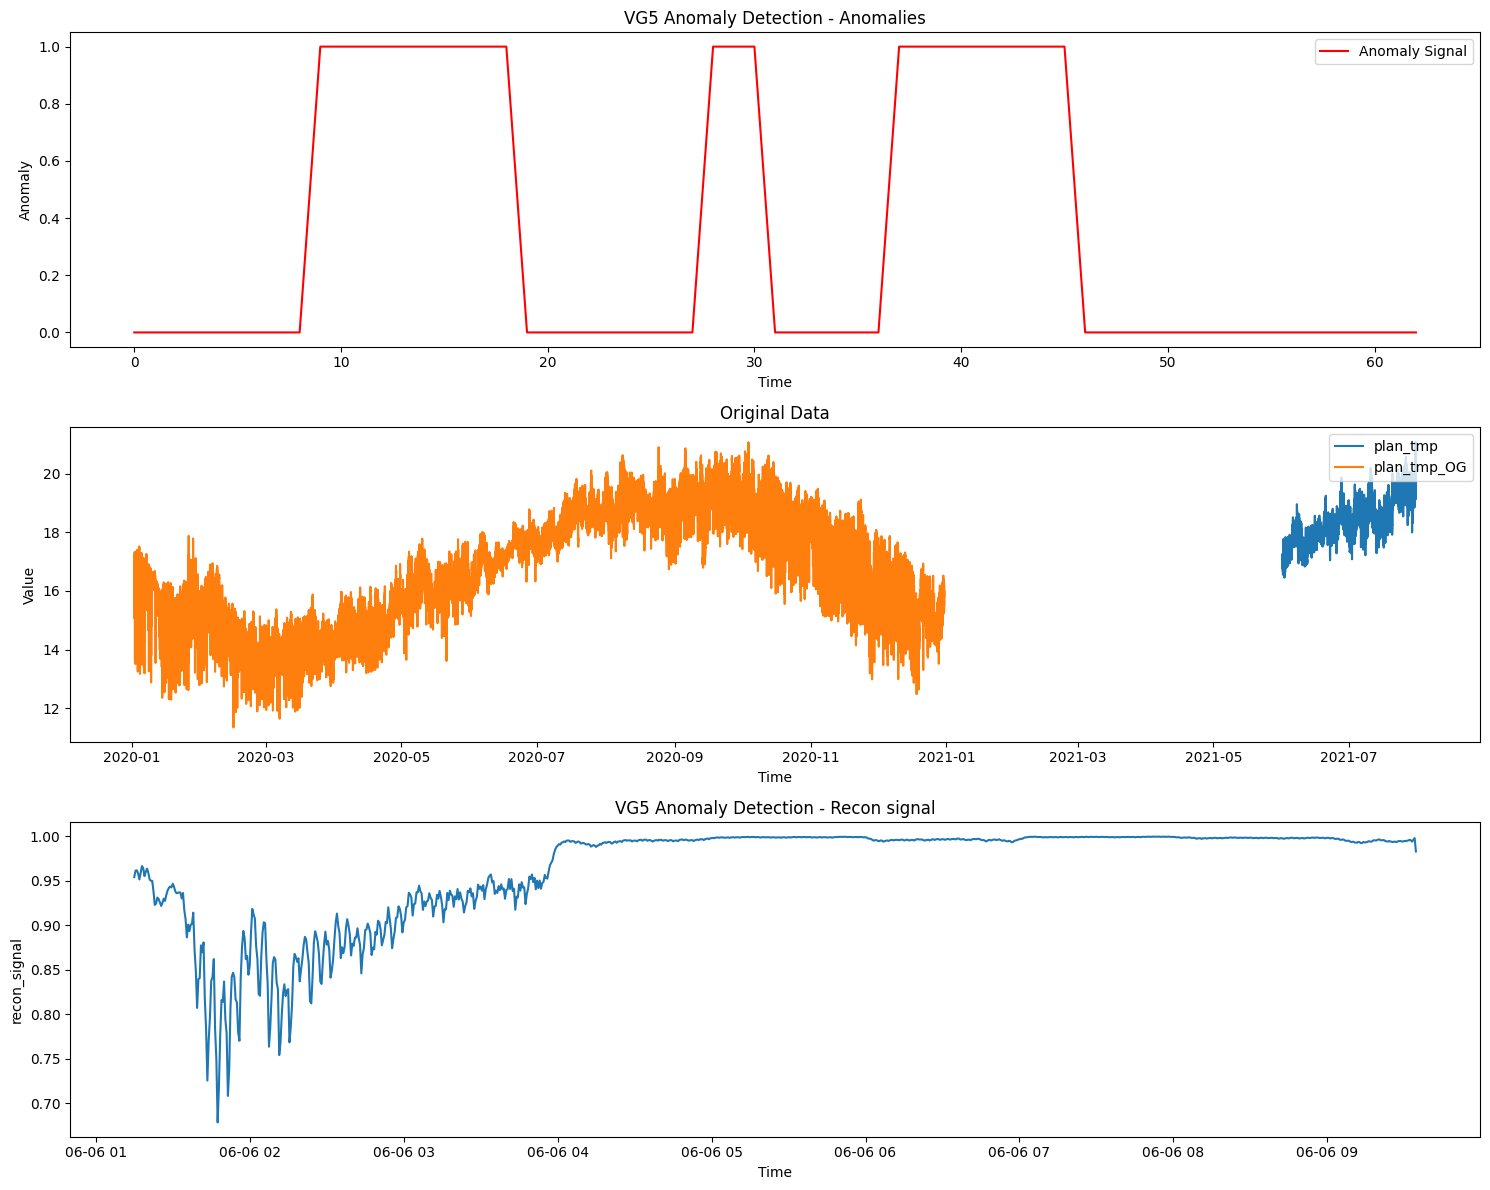

In [ ]:
plot_anomaly_detection(vg5_s1, alarm_signal, recon_signals, title="VG5 Anomaly Detection")
